# scratch work

In [132]:
import jax

jax.config.update("jax_enable_x64", True)
import astropy.units as u
import jax.numpy as jnp

# from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from numpy.polynomial import chebyshev

from jorbit import Particle
from jorbit.astrometry.sky_projection import sky_sep
# from jorbit.utils.horizons import get_observer_positions


In [61]:
t0 = Time("2020-01-01")
forward_times = t0 + jnp.arange(0, 20.001, 1*u.hour.to(u.year))*u.year
reverse_times = t0 - jnp.arange(0, 20.001, 1*u.hour.to(u.year))*u.year

forward_pos = jnp.load("forward_pos.npy")
reverse_pos = jnp.load("reverse_pos.npy")

In [62]:
t0 = Time("2020-01-01")

obj = Horizons(id="K19J92Q", location="500@0", epochs=t0.tdb.jd)
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
true_x0, true_v0

(Array([ 1.599354  , -1.16381977, -0.44247571], dtype=float64),
 Array([0.00918443, 0.0083583 , 0.00350141], dtype=float64))

In [63]:
p = Particle(x=true_x0, v=true_v0, time=t0, gravity="newtonian solar system")

In [64]:
eph = p.ephemeris(forward_times[::10], observer=forward_pos[::10])

In [67]:
obj = Horizons(id="K19J92Q", location="500@399", epochs=forward_times[::10][::500].tdb.jd)
coord = obj.ephemerides(quantities=1, extra_precision=True)
s = SkyCoord(coord["RA"], coord["DEC"], unit=(u.deg, u.deg))
s.separation(eph[::500])

<Angle [4.55251928e-04, 2.32567033e-04, 2.07186966e-04, 2.66293487e-04,
        8.14095239e-05, 4.23075823e-04, 1.03454809e-04, 3.42812415e-04,
        2.64761012e-04, 8.17633283e-05, 3.01829684e-04, 1.57968567e-04,
        4.42224761e-04, 3.00463282e-04, 1.67660842e-04, 2.77754743e-04,
        8.45039667e-05, 3.30191353e-04, 1.95982880e-04, 3.96204101e-04,
        3.17418952e-04, 5.91385209e-05, 2.83366657e-04, 2.55215108e-04,
        3.49302266e-04, 2.53033321e-04, 1.97992737e-04, 3.05621807e-04,
        2.39945292e-04, 2.84931199e-04, 2.23822896e-04, 3.47745901e-04,
        3.55462059e-04, 2.00483221e-04, 2.87573346e-04, 2.49992078e-04] deg>

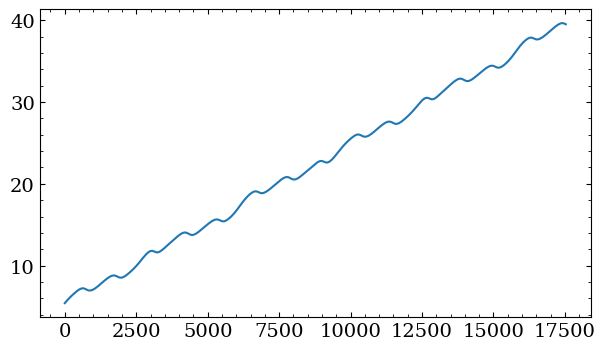

In [68]:
r = jnp.unwrap(eph.ra.rad)
plt.plot(r)

In [98]:
from jorbit.ephemeris.ephemeris import Ephemeris

eph_ex = Ephemeris(
        earliest_time=Time("2000-01-01"),
        latest_time=Time("2040-01-01"),
        ssos="default planets",
)

eph_ex.processor.init.shape, eph_ex.processor.intlen.shape, eph_ex.processor.coeffs.shape

((10,), (10,), (10, 14, 3, 1824))

In [99]:
eph_ex.processor.intlen[0] * u.hour.to(u.year)

Array(157.70020534, dtype=float64)

In [205]:
degree = 10

t = forward_times.tdb.jd[::10]
x = jnp.unwrap(eph.ra.rad)

chunk_size = 30 # days
num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

i = 0
inds = (t >= t[0] + i*chunk_size) & (t < t[0] + (i+1)*chunk_size)
t_chunk = t[inds]
x_chunk = x[inds]

# Scale time to [-1, 1] domain
t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

# Fit Chebyshev polynomials
coefficients = chebyshev.chebfit(t_scaled, x_chunk, degree)

# Evaluate Chebyshev polynomials
x_fit = chebyshev.chebval(t_scaled, coefficients)

# j = 2 * (Time("2020-01-02").tdb.jd - t_min) / (t_max - t_min) - 1
# j

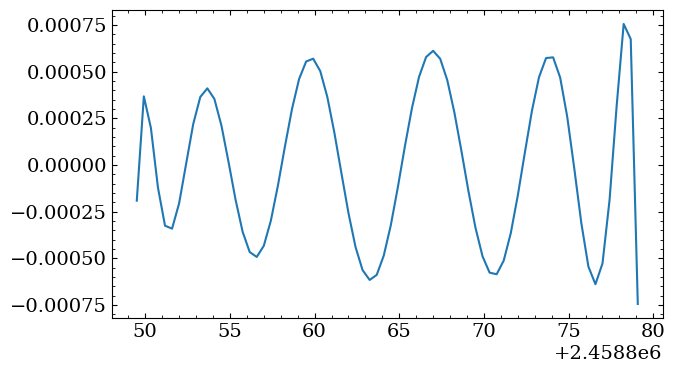

In [202]:
plt.plot(t_chunk, (x_chunk-x_fit)*u.rad.to(u.arcsec))
# plt.plot(t_chunk, )

In [196]:
x_chunk

Array([5.71407655, 5.71799588, 5.72191133, 5.72582289, 5.72973056,
       5.73363435, 5.73753425, 5.74143026, 5.74532238, 5.74921061,
       5.75309496, 5.75697543, 5.76085202, 5.76472474, 5.76859359,
       5.77245858, 5.77631972, 5.78017701, 5.78403046, 5.78788009,
       5.7917259 , 5.79556792, 5.79940614, 5.80324058, 5.80707126,
       5.8108982 , 5.8147214 , 5.81854088, 5.82235665, 5.82616874,
       5.82997714, 5.83378189, 5.83758297, 5.84138042, 5.84517423,
       5.84896442, 5.85275099, 5.85653396, 5.86031333, 5.8640891 ,
       5.86786129, 5.87162989, 5.87539491, 5.87915635, 5.88291422,
       5.88666852, 5.89041925, 5.89416641, 5.89791001, 5.90165003,
       5.9053865 , 5.9091194 , 5.91284875, 5.91657453, 5.92029674,
       5.9240154 , 5.9277305 , 5.93144205, 5.93515003, 5.93885446,
       5.94255533, 5.94625265, 5.94994642, 5.95363664, 5.95732331,
       5.96100643, 5.96468601, 5.96836206, 5.97203456, 5.97570354,
       5.97936898, 5.9830309 ], dtype=float64)

In [247]:

degree = 8

t = forward_times.tdb.jd[::10]

r = jnp.unwrap(eph.ra.rad)
d = eph.dec.rad

chunk_size = 30  # days
num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

init = (t[0] - 2451545.0) * 86400.0
# intlen = (t[-1] - t[0]) * 86400.0
intlen = chunk_size * 86400.0

coeffs = jnp.zeros((degree + 1, 2, num_chunks))
for i in range(num_chunks):
    inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
    t_chunk = t[inds]
    r_chunk = r[inds]
    d_chunk = d[inds]

    # Scale time to [-1, 1] domain
    t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
    t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

    # Fit Chebyshev polynomials
    coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
    coefficients = coefficients[::-1]
    coeffs = coeffs.at[:, 0, i].set(coefficients)

    coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
    coefficients = coefficients[::-1]
    coeffs = coeffs.at[:, 1, i].set(coefficients)



t = forward_times.tdb.jd[::10]
x = jnp.unwrap(eph.ra.rad)
# x = eph.dec.rad

chunk_size = 30 # days
num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

i = 0
inds = (t >= t[0] + i*chunk_size) & (t < t[0] + (i+1)*chunk_size)
t_chunk = t[inds]
x_chunk = x[inds]

# Scale time to [-1, 1] domain
t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

# Fit Chebyshev polynomials
coefficients = chebyshev.chebfit(t_scaled, x_chunk, degree)

# Evaluate Chebyshev polynomials
# x_fit = chebyshev.chebval(t_scaled, coefficients)

t_scaled = 2 * (Time("2020-01-02").tdb.jd - t_min) / (t_max - t_min) - 1
print(t_scaled)
x_fit = chebyshev.chebval(t_scaled, coefficients)
x_fit

-0.9333333333022893


np.float64(5.432086504004087)

In [259]:
# @jax.jit
def eval_cheby(coefficients, x):
    b_ii = jnp.zeros(2)
    b_i = jnp.zeros(2)

    def scan_func(X, a):
        b_i, b_ii = X
        tmp = b_i
        b_i = a + 2 * x * b_i - b_ii
        b_ii = tmp
        return (b_i, b_ii), b_i

    (b_i, b_ii), s = jax.lax.scan(scan_func, (b_i, b_ii), coefficients[:-1])
    return coefficients[-1] + x * b_i - b_ii, s

# @jax.jit
def _individual_state(init, intlen, coeffs, tdb):
    tdb2 = 0.0  # leaving in case we ever decide to increase the time precision and use 2 floats
    _, _, n = coeffs.shape

    # 2451545.0 is the J2000 epoch in TDB
    index1, offset1 = jnp.divmod((tdb - 2451545.0) * 86400.0 - init, intlen)
    index2, offset2 = jnp.divmod(tdb2 * 86400.0, intlen)
    index3, offset = jnp.divmod(offset1 + offset2, intlen)
    index = (index1 + index2 + index3).astype(int)
    print(index)
    print(offset1)
    print(offset)

    omegas = index == n
    index = jnp.where(omegas, index - 1, index)
    offset = jnp.where(omegas, offset + intlen, offset)

    coefficients = coeffs[:, :, index]

    s = 2.0 * offset / intlen - 1.0
    print(s)

    # Position
    (approx_ra, approx_dec), _ = eval_cheby(coefficients, s)  # in km here
    # return eval_cheby(coefficients, s)[0]
    return approx_ra , approx_dec

_individual_state(init, intlen, coeffs, Time("2020-01-02").tdb.jd)

0
86400.00004029274
86400.00004029274
-0.9333333333022432


(Array(5.4320865, dtype=float64), Array(-0.29445966, dtype=float64))

In [250]:
_individual_state(init, intlen, coeffs, Time("2020-01-02").tdb.jd)

0
86400.00004029274
86400.00004029274
-0.9333333333022432


Array([ 5.4320865 , -0.29445966], dtype=float64)

In [235]:
chebyshev.chebval(t_scaled, coeffs[:, 0, 0])

np.float64(5.432086504004087)

In [223]:
intlen

np.float64(631152000.0000403)

In [188]:
coeffs.shape

(9, 2, 244)

In [252]:
def generate_ephem(particle_name, step_size, chunk_size, degree):
    # step size in hours, chunk size in days

    obj = Horizons(id=particle_name, location="500@0", epochs=t0.tdb.jd)
    vecs = obj.vectors(refplane="earth")
    x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
    v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
    particle = Particle(x=x0, v=v0, time=t0, gravity="newtonian solar system")

    t = forward_times[::step_size].tdb.jd

    eph = particle.ephemeris(t, observer=forward_pos[::step_size])

    r = jnp.unwrap(eph.ra.rad)
    d = eph.dec.rad

    num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

    init = (t[0] - 2451545.0) * 86400.0
    intlen = chunk_size * 86400.0

    coeffs = jnp.zeros((degree + 1, 2, num_chunks))
    for i in range(num_chunks):
        inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
        t_chunk = t[inds]
        r_chunk = r[inds]
        d_chunk = d[inds]

        # Scale time to [-1, 1] domain
        t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
        t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

        # Fit Chebyshev polynomials
        coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
        coefficients = coefficients[::-1]
        coeffs = coeffs.at[:, 0, i].set(coefficients)

        coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
        coefficients = coefficients[::-1]
        coeffs = coeffs.at[:, 1, i].set(coefficients)

    return init, intlen, coeffs



def test_ephem(particle_name, ephem, t):
    obj = Horizons(id=particle_name, location="500@399", epochs=t.utc.jd, id_type="smallbody")
    coord = obj.ephemerides(quantities=1, extra_precision=True)
    s = SkyCoord(coord["RA"], coord["DEC"], unit=(u.deg, u.deg))

    ra, dec = _individual_state(*ephem, t.tdb.jd)

    return ra, dec, sky_sep(ra, dec, s.ra.rad, s.dec.rad)


In [253]:
q = generate_ephem("K19J92Q", 10, 30, 10)

In [260]:
delta = np.random.uniform(0, 40)
t_test = t0 + delta * u.year
test_ephem("K19J92Q", q, t0+10.1434*u.day+10*u.year)

122
228389.76031696796
228389.76031696796
-0.8237733330887593


(Array(22.4999006, dtype=float64),
 Array(-0.22016556, dtype=float64),
 Array([0.17733964], dtype=float64))

In [20]:
from jorbit.accelerations import create_newtonian_ephemeris_acceleration_func
from jorbit.ephemeris.ephemeris import Ephemeris
from jorbit.integrators.ias15 import ias15_evolve, initialize_ias15_integrator_state
from jorbit.utils.states import SystemState

eph = Ephemeris(
        earliest_time=Time("2000-01-01"),
        latest_time=Time("2040-01-01"),
        ssos="default planets",
)
acc_func = create_newtonian_ephemeris_acceleration_func(eph.processor)


state = SystemState(
    tracer_positions=jnp.repeat(true_x0[None], 100_000, axis=0),
    tracer_velocities=jnp.repeat(true_v0[None], 100_000, axis=0),
    massive_positions=jnp.empty((0, 3)),
    massive_velocities=jnp.empty((0, 3)),
    log_gms=jnp.empty(0),
    time=t0.tdb.jd,
    acceleration_func_kwargs={}
)
a0 = acc_func(state)
integrator_state = initialize_ias15_integrator_state(a0)


In [22]:
ias15_evolve(
    state,
    acc_func,
    jnp.array([(t0+300*u.day).tdb.jd]),
    integrator_state,
)

(Array([[[1.84947514, 1.73404375, 0.72585711],
         [1.84947514, 1.73404375, 0.72585711],
         [1.84947514, 1.73404375, 0.72585711],
         ...,
         [1.84947514, 1.73404375, 0.72585711],
         [1.84947514, 1.73404375, 0.72585711],
         [1.84947514, 1.73404375, 0.72585711]]], dtype=float64),
 Array([[[-0.00588021,  0.00754745,  0.00294143],
         [-0.00588021,  0.00754745,  0.00294143],
         [-0.00588021,  0.00754745,  0.00294143],
         ...,
         [-0.00588021,  0.00754745,  0.00294143],
         [-0.00588021,  0.00754745,  0.00294143],
         [-0.00588021,  0.00754745,  0.00294143]]], dtype=float64),
 SystemState(tracer_positions=Array([[1.84947514, 1.73404375, 0.72585711],
        [1.84947514, 1.73404375, 0.72585711],
        [1.84947514, 1.73404375, 0.72585711],
        ...,
        [1.84947514, 1.73404375, 0.72585711],
        [1.84947514, 1.73404375, 0.72585711],
        [1.84947514, 1.73404375, 0.72585711]], dtype=float64), tracer_velocities=A

In [33]:
import numpy as np

np.zeros((2000, 1_000_000), dtype=np.uint16).nbytes / 1e9

4.0

In [29]:
j = np.zeros(1_000_000, dtype=np.uint16)

inds = np.random.randint(0, 1_000_000, 100_000)
j[inds] = 1

%timeit q = np.where(j == 1)

1.95 ms ± 9.15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
40*u.year.to(u.week)

2087.1428571428573

In [51]:
from astropy.utils.data import download_file

download_file("https://zenodo.org/records/10161743/files/ERS_DataSynthesis_Zenodo.zip?download=1", cache=True)

'/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents'

In [41]:
from glob import glob

glob("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents/*")

[]

In [42]:
import zipfile

with zipfile.ZipFile("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents", 'r') as zip_ref:
    # Extract all contents
    zip_ref.extractall("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/")

In [ ]:
# some options:
# precompute everything, save chebyshev coeffs
# downsides: large file size. only piecewise by year requires np.zeros((1_000_000, 40, 2, 10)), ~6.4GB
# upside: just have to evaluate the chebyshev polynomials, no integrations, and can check everything

# precompute everything, save helpix tile
# downside: have to pick the right tile size, then do another integration with the objects in the tile
# upside: potentially smaller file size to store. assuming >255 tiles, np.zeros((1_000_000, 40*12)) is ~1GB

(10, 14, 3, 1824)